## 改編ContextUnet及相關代碼，使其首先對二維的情況適用。並於diffusers.Unet2DModel作比較並加以優化。最後再改寫爲3維的情形。
- 經試用diffusers的Unet2DModel，發現loss從0.3降到0.2但仍然很高，説明存在非Unet2DModel的問題可以優化
- 改用diffusers的DDMPScheduler和DDPMPipeline后，loss降低至0.1以下，有時甚至可以低至0.004，可見我的代碼問題主要出在DDPM部分。DDPMScheduler部分比較簡短，似乎沒有問題，所以問題應該在DDPMPipeline裏某一部分代碼是我代碼欠缺的。
- 我在DDPMScheduler部分有一個typo，導致beta_t一直很小，修正后loss從0.2能降低至0.02, 維持在0.1以下
- 用diffusers的DDPMScheduler似乎效果要好一些，loss總是比我的DDPMScheduler要小一點。儅epoch為19時，前者的loss約0.02，後者loss約0.07。而且前者還支持3維圖像的加噪，不如直接用別人的輪子。但我想知道爲什麽我的loss會高一些。
- 我意識到別人的DDPMScheduler在sample函數中沒有兼容輸入參數，所以歸根結底還是需要我的DDPMscheduler。不過我可以先用別人的來debug我的ContextUnet.
- 我需要將我的ContextUnet擴展兼容不同維度的照片，畢竟我本身也需要和原文獻對比完了再拓展到三維的情形
- 我已將我的ContextUnet轉成了2維的模式，與diffusers.Unet2DModel的loss=0.037相比，我的Unet的loss=0.07。同時我的Unet生成的圖像看上去很奇怪，説明我的Unet也有問題。我需要將代碼退回原Unet，並檢查問題所在。
- 我將紅移方向的像素的數量限制在了64.以此比較兩個Unet的差別。經比較：\
Unet2DModel loss：0.03, 0.0655, 0.05, 0.02, 0.05\
ContextUnet loss: 0.1, 0.16, 0.1, 0.2186, 0.06
- 我把ContextUnet退回到了原作者的版本，結果loss=0.05，輸出的照片也不錯。我主要的改動是改回了他原用的normalization函數，其中還有個參數swish。有時間我可以研究一下具體是哪裏影響了訓練的結果。另外我發現了要想tensorboard的圖綫獨立美觀，需要把他們放在不同的文件夾下
- 經過驗證，GroupNorm比batchNorm效果要好
- 已擴展爲接受不同維度的情形
- 融合cond, guide_w, drop_out這些參數
- 生成的21cm圖像該暗的地方不夠暗，似乎換成MNIST的數字圖像就沒問題
- 我用diffusion模型生成MNIST的數字時發現，儘管生成的數據的範圍也存在負數數值，如-0.1,但畫出來的圖像卻是理想的黑色。數據的分佈與21cm的結果的分佈沒多大差別，我現在打算把代碼退回到21cm的情形
- 我統一了ddpm21cm這個module，能統一實現訓練和生成樣本，但目前有個bug， sample時總是會cuda out of memory，然而單獨resume model並sample就不會。
- 解決了，問題出在我忘了寫with torch.no_grad():
- 接下來就是生成800個lightcones，與此同時研究如何計算global signal以及power spectrum

In [1]:
from dataclasses import dataclass
import h5py
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
# from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
# from abc import ABC, abstractmethod
import torch.nn.functional as F
import math
# from PIL import Image
import os
from torch.utils.tensorboard import SummaryWriter
import copy
from tqdm.auto import tqdm
# from torchvision import transforms
# from diffusers import UNet2DModel#, UNet3DConditionModel
# from diffusers import DDPMScheduler
from diffusers.utils import make_image_grid
import datetime
from pathlib import Path
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import notebook_launcher, Accelerator
from huggingface_hub import create_repo, upload_folder

from load_h5 import Dataset4h5
from context_unet import ContextUnet

from huggingface_hub import notebook_login

# Add noise:

\begin{align*}
x_t &\sim \mathcal N\left(\sqrt{1-\beta_t}\ x_{t-1},\ \beta_t \right) \\
x_t &\equiv \sqrt{1-\beta_t}\ x_{t-1} + \sqrt{\beta_t}\ \epsilon\\
\epsilon &\sim \mathcal N(0,1)\\
\alpha_t & \equiv 1 - \beta_t\\
& ...\\
x_t &= \sqrt{\bar {\alpha_t}} x_0 + \epsilon\ \sqrt{1 - \bar{\alpha_t}}\\
\bar {\alpha_t} &\equiv \prod_{i=1}^t \alpha_i\\
&= \exp\left({\ln{\prod_{i=1}^t \alpha_i}}\right)\\
&= \exp\left({\sum_{i=1}^t\ln{ \alpha_i}}\right)
\end{align*}

In [2]:
class DDPMScheduler(nn.Module):
    def __init__(self, betas: tuple, num_timesteps: int, img_shape: list, device='cpu'):
        super().__init__()
        
        beta_1, beta_T = betas
        assert 0 < beta_1 <= beta_T <= 1, "ensure 0 < beta_1 <= beta_T <= 1"
        self.device = device
        self.num_timesteps = num_timesteps
        self.img_shape = img_shape
        self.beta_t = torch.linspace(beta_1, beta_T, self.num_timesteps) #* (beta_T-beta_1) + beta_1
        self.beta_t = self.beta_t.to(self.device)

        # self.drop_prob = drop_prob
        # self.cond = cond
        self.alpha_t = 1 - self.beta_t
        # self.bar_alpha_t = torch.exp(torch.cumsum(torch.log(self.alpha_t), dim=0))
        self.bar_alpha_t = torch.cumprod(self.alpha_t, dim=0)

    def add_noise(self, clean_images):
        shape = clean_images.shape
        expand = torch.ones(len(shape)-1, dtype=int)
        # ts_expand = ts.view(ts.shape[0], *expand.tolist())
        # expand = [1 for i in range(len(shape)-1)]

        noise = torch.randn_like(clean_images).to(self.device)
        ts = torch.randint(0, self.num_timesteps, (shape[0],)).to(self.device)
                
        # test_expand = test.view(test.shape[0],*expand)
        # extend_dim = [None for i in range(shape.dim()-1)]
        noisy_images = (
            clean_images * torch.sqrt(self.bar_alpha_t[ts]).view(shape[0], *expand.tolist())
            + noise * torch.sqrt(1-self.bar_alpha_t[ts]).view(shape[0], *expand.tolist())
            )
        # print(x_t.shape)

        return noisy_images, noise, ts

    def sample(self, nn_model, params, device, guide_w = 0):
        n_sample = len(params) #params.shape[0]
        # print("params.shape[0], len(params)", params.shape[0], len(params))
        x_i = torch.randn(n_sample, *self.img_shape).to(device)
        # print("x_i.shape =", x_i.shape)
        # print("x_i.shape =", x_i.shape)
        if guide_w != -1:
            c_i = params
            uncond_tokens = torch.zeros(int(n_sample), params.shape[1]).to(device)
            # uncond_tokens = torch.tensor(np.float32(np.array([0,0]))).to(device)
            # uncond_tokens = uncond_tokens.repeat(int(n_sample),1)
            c_i = torch.cat((c_i, uncond_tokens), 0)

        x_i_entire = [] # keep track of generated steps in case want to plot something
        # print("self.num_timesteps =", self.num_timesteps)
        # for i in range(self.num_timesteps, 0, -1):
        # print(f'sampling!!!')
        pbar_sample = tqdm(total=self.num_timesteps)
        pbar_sample.set_description("Sampling")
        for i in reversed(range(0, self.num_timesteps)):
            # print(f'sampling timestep {i:4d}',end='\r')
            t_is = torch.tensor([i]).to(device)
            t_is = t_is.repeat(n_sample)

            z = torch.randn(n_sample, *self.img_shape).to(device) if i > 0 else 0

            if guide_w == -1:
                # eps = nn_model(x_i, t_is, return_dict=False)[0]
                eps = nn_model(x_i, t_is)
                # x_i = 1/torch.sqrt(self.alpha_t[i])*(x_i-eps*self.beta_t[i]/torch.sqrt(1-self.bar_alpha_t[i])) + torch.sqrt(self.beta_t[i])*z
            else:
                # double batch
                x_i = x_i.repeat(2, *torch.ones(len(self.img_shape), dtype=int).tolist())
                t_is = t_is.repeat(2)

                # split predictions and compute weighting
                # print("nn_model input shape", x_i.shape, t_is.shape, c_i.shape)
                eps = nn_model(x_i, t_is, c_i)
                eps1 = eps[:n_sample]
                eps2 = eps[n_sample:]
                eps = eps1 + guide_w*(eps1 - eps2)
                # eps = (1+guide_w)*eps1 - guide_w*eps2
                x_i = x_i[:n_sample]
                # x_i = 1/torch.sqrt(self.alpha_t[i])*(x_i-eps*self.beta_t[i]/torch.sqrt(1-self.bar_alpha_t[i])) + torch.sqrt(self.beta_t[i])*z
            
            # print("x_i.shape =", x_i.shape)
            x_i = 1/torch.sqrt(self.alpha_t[i])*(x_i-eps*self.beta_t[i]/torch.sqrt(1-self.bar_alpha_t[i])) + torch.sqrt(self.beta_t[i])*z
            
            pbar_sample.update(1)
            # pbar_sample.set_postfix(step=i)
            
            # print("x_i.shape =", x_i.shape)
            # store only part of the intermediate steps
            if i%20==0:# or i==0:# or i<8:
                x_i_entire.append(x_i.detach().cpu().numpy())
        x_i = x_i.detach().cpu().numpy()
        x_i_entire = np.array(x_i_entire)
        return x_i, x_i_entire


# ddpm_scheduler = DDPMScheduler((1e-4,0.02),10)
# noisy_images, noise, ts = ddpm_scheduler.add_noise(images)

In [3]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model):
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())
        

In [4]:
@dataclass
class TrainConfig:
    ###########################
    ## hardcoding these here ##
    ###########################
    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    dataset_name = "/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8.h5"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # repeat = 2

    # dim = 2
    dim = 2
    stride = (2,2) if dim == 2 else (2,2,4)
    num_image = 2560
    HII_DIM = 64
    num_redshift = 512#256#256#64#512#128
    channel = 1
    img_shape = (channel, HII_DIM, num_redshift) if dim == 2 else (channel, HII_DIM, HII_DIM, num_redshift)

    n_epoch = 15#2#5#25 # 120
    num_timesteps = 1000#1000 # 1000, 500; DDPM time steps
    batch_size = 10#20#2#100 # 10
    # n_sample = 24 # 64, the number of samples in sampling process
    n_param = 2
    guide_w = 0#-1#0#-1#0.1#[0,0.1] #[0,0.5,2] strength of generative guidance
    drop_prob = 0.28 # only takes effect when guide_w != -1
    ema=True # whether to use ema
    ema_rate=0.995

    # seed = 0
    # save_dir = './outputs/'

    save_freq = 0#.1 # the period of sampling
    # general parameters for the name and logger    
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    lrate = 1e-4
    lr_warmup_steps = 0#5#00
    output_dir = "./outputs/"
    save_name = os.path.join(output_dir, 'model_state.pth')
    # save_freq = 1 #10 # the period of saving model
    # cond = True # if training using the conditional information
    # lr_decay = False #True# if using the learning rate decay
    resume = save_name # if resume from the trained checkpoints
    # params_single = torch.tensor([0.2,0.80000023])
    # params = torch.tile(params_single,(n_sample,1)).to(device)
    # params =  params
    # data_dir = './data' # data directory


    mixed_precision = "fp16"
    gradient_accumulation_steps = 1

    # date = datetime.datetime.now().strftime("%m%d-%H%M")
    # run_name = f'{date}' # the unique name of each experiment

# config = TrainConfig()
# print("device =", config.device)

In [5]:
# @dataclass
class DDPM21CM:
    def __init__(self):
        config = TrainConfig()
        # date = datetime.datetime.now().strftime("%m%d-%H%M")
        config.run_name = datetime.datetime.now().strftime("%m%d-%H%M") # the unique name of each experiment
        self.config = config
        # dataset = Dataset4h5(config.dataset_name, num_image=config.num_image, HII_DIM=config.HII_DIM, num_redshift=config.num_redshift, drop_prob=config.drop_prob, dim=config.dim)
        # # self.shape_loaded = dataset.images.shape
        # # print("shape_loaded =", self.shape_loaded)
        # self.dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
        # del dataset
        self.ddpm = DDPMScheduler(betas=(1e-4, 0.02), num_timesteps=config.num_timesteps, img_shape=config.img_shape, device=config.device)

        # initialize the unet
        self.nn_model = ContextUnet(n_param=config.n_param, image_size=config.HII_DIM, dim=config.dim, stride=config.stride)

        if config.resume and os.path.exists(config.resume):
            # resume_file = os.path.join(config.output_dir, f"{config.resume}")
            self.nn_model.load_state_dict(torch.load(config.resume)['unet_state_dict'])
            print(f"resumed nn_model from {config.resume}")
        # nn_model = ContextUnet(n_param=1, image_size=28)
        self.nn_model.train()
        self.nn_model.to(self.ddpm.device)
        # print("nn_model.device =", ddpm.device)
        # number of parameters to be trained
        self.number_of_params = sum(x.numel() for x in self.nn_model.parameters())
        print(f"Number of parameters for nn_model: {self.number_of_params}")

        # whether to use ema
        if config.ema:
            self.ema = EMA(config.ema_rate)
            if config.resume and os.path.exists(config.resume):
                self.ema_model = ContextUnet(n_param=config.n_param, image_size=config.HII_DIM, dim=config.dim, stride=config.stride).to(config.device)
                self.ema_model.load_state_dict(torch.load(config.resume)['ema_unet_state_dict'])
                print(f"resumed ema_model from {config.resume}")
            else:
                self.ema_model = copy.deepcopy(self.nn_model).eval().requires_grad_(False)

        self.optimizer = torch.optim.AdamW(self.nn_model.parameters(), lr=config.lrate)
        self.lr_scheduler = get_cosine_schedule_with_warmup(
            optimizer=self.optimizer,
            num_warmup_steps=config.lr_warmup_steps,
            num_training_steps=(int(config.num_image/config.batch_size) * config.n_epoch),
            # num_training_steps=(len(self.dataloader) * config.n_epoch),
        )

    def load(self):
        dataset = Dataset4h5(self.config.dataset_name, num_image=self.config.num_image, HII_DIM=self.config.HII_DIM, num_redshift=self.config.num_redshift, drop_prob=self.config.drop_prob, dim=self.config.dim)
        # self.shape_loaded = dataset.images.shape
        # print("shape_loaded =", self.shape_loaded)
        self.dataloader = DataLoader(dataset, batch_size=self.config.batch_size, shuffle=True)
        # del dataset
        # self.accelerate(self.config)
        del dataset

    # def accelerate(self):

    def train(self):
        ###################      
        ## training loop ##
        ###################
        # plot_unet = True
        self.load()
        self.accelerator = Accelerator(
            mixed_precision=self.config.mixed_precision,
            gradient_accumulation_steps=self.config.gradient_accumulation_steps,
            log_with="tensorboard",
            project_dir=os.path.join(self.config.output_dir, "logs"),
        )
        if self.accelerator.is_main_process:
            if self.config.output_dir is not None:
                os.makedirs(self.config.output_dir, exist_ok=True)
            if self.config.push_to_hub:
                self.repo_id = create_repo(
                    repo_id=self.config.hub_model_id or Path(self.config.output_dir).name, exist_ok=True
                ).repo_id
            self.accelerator.init_trackers(f"{self.config.run_name}")

        self.nn_model, self.optimizer, self.dataloader, self.lr_scheduler = \
            self.accelerator.prepare(
            self.nn_model, self.optimizer, self.dataloader, self.lr_scheduler
            )
            
        global_step = 0
        for ep in range(self.config.n_epoch):
            self.ddpm.train()

            pbar_train = tqdm(total=len(self.dataloader), disable=not self.accelerator.is_local_main_process)
            pbar_train.set_description(f"Epoch {ep}")
            for i, (x, c) in enumerate(self.dataloader):
                with self.accelerator.accumulate(self.nn_model):
                    x = x.to(self.config.device)
                    xt, noise, ts = self.ddpm.add_noise(x)
                    
                    if self.config.guide_w == -1:
                        noise_pred = self.nn_model(xt, ts)
                    else:
                        c = c.to(self.config.device)
                        noise_pred = self.nn_model(xt, ts, c)
                    
                    loss = F.mse_loss(noise, noise_pred)
                    self.accelerator.backward(loss)
                    self.accelerator.clip_grad_norm_(self.nn_model.parameters(), 1)
                    self.optimizer.step()
                    self.lr_scheduler.step()
                    self.optimizer.zero_grad()

                # ema update
                if self.config.ema:
                    self.ema.step_ema(self.ema_model, self.nn_model)

                pbar_train.update(1)
                logs = dict(
                    loss=loss.detach().item(),
                    lr=self.optimizer.param_groups[0]['lr'],
                    step=global_step
                )
                pbar_train.set_postfix(**logs)

                self.accelerator.log(logs, step=global_step)
                global_step += 1

            # if ep == config.n_epoch-1 or (ep+1)*config.save_freq==1:
            self.save(ep)

        del self.nn_model
        if self.config.ema:
            del self.ema_model
        torch.cuda.empty_cache()

    def save(self, ep):
        # save model
        if self.accelerator.is_main_process:
            if ep == self.config.n_epoch-1 or (ep+1)*self.config.save_freq==1:
                self.nn_model.eval()
                with torch.no_grad():
                    if self.config.push_to_hub:
                        upload_folder(
                            repo_id = self.repo_id,
                            folder_path = ".",#config.output_dir,
                            commit_message = f"{self.config.run_name}",
                            ignore_patterns = ["step_*", "epoch_*", "*.npy", "__pycache__"],
                            )
                    if self.config.save_name:
                        model_state = {
                            'epoch': ep,
                            'unet_state_dict': self.nn_model.state_dict(),
                            'ema_unet_state_dict': self.ema_model.state_dict(),
                            }
                        torch.save(model_state, self.config.save_name)
                        print('saved model at ' + self.config.save_name)
                        # print('saved model at ' + config.save_dir + f"model_epoch_{ep}_test_{config.run_name}.pth")

    def sample(self, file, params:torch.tensor=None, ema=False, entire=False):
        # n_sample = params.shape[0]
        params = params or torch.tensor([0.2,0.8]).repeat(24,1)
        assert params.dim() == 2, "params must be a 2D torch.tensor"
        # print("params =", params)
        # print("params =", params)
        # print("len(params) =", len(params))
        # model = self.ema_model if ema else self.nn_model
        # del self.ema_model, self.nn
        # params = torch.tile(params, (n_sample,1)).to(device)

        nn_model = ContextUnet(n_param=self.config.n_param, image_size=self.config.HII_DIM, dim=self.config.dim, stride=self.config.stride).to(self.config.device)
        if ema:
            nn_model.load_state_dict(torch.load(file)['ema_unet_state_dict'])
        else:
            nn_model.load_state_dict(torch.load(file)['unet_state_dict'])
        print(f"nn_model resumed from {file}")
        # nn_model = ContextUnet(n_param=1, image_size=28)
        # nn_model.train()
        nn_model.to(self.ddpm.device)
        nn_model.eval()

        # self.ema_model = ContextUnet(n_param=config.n_param, image_size=config.HII_DIM, dim=config.dim, stride=config.stride).to(config.device)
        # self.ema_model.load_state_dict(torch.load(os.path.join(config.output_dir, f"{config.resume}"))['ema_unet_state_dict'])
        # print(f"resumed ema_model from {config.resume}")

        with torch.no_grad():
            x_last, x_entire = self.ddpm.sample(
                nn_model=nn_model, 
                params=params.to(self.config.device), 
                device=self.config.device, 
                guide_w=self.config.guide_w
                )

        np.save(os.path.join(self.config.output_dir, f"{self.config.run_name}{'ema' if ema else ''}.npy"), x_last)

        if entire:
            np.save(os.path.join(self.config.output_dir, f"{self.config.run_name}{'ema' if ema else ''}_entire.npy"), x_last)
# print("device =", config.device)

In [6]:
notebook_login()

In [7]:
if __name__ == "__main__":
    # args = (config, nn_model, ddpm, optimizer, dataloader, lr_scheduler)
    repeat = 10
    for i in range(repeat):
        print(f" round {i} ".center(50, '-'))
        ddpm21cm = DDPM21CM()
        print(f"run_name = {ddpm21cm.config.run_name}")
        notebook_launcher(ddpm21cm.train, num_processes=1)

Number of parameters for nn_model: 111048705
run_name = 0523-1704
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1378462314605713]
params rescaled to [0.0, 0.9995994165819857]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1718
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1661419868469238]
params rescaled to [0.0, 0.9999958400767995]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1732
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1875841617584229]
params rescaled to [0.0, 0.9996822280943722]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1745
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1458096504211426]
params rescaled to [0.0, 0.9998883049763877]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1759
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1824936866760254]
params rescaled to [0.0, 0.9997530171043563]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1813
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1919512748718262]
params rescaled to [0.0, 0.9996232858956116]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1827
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1501460075378418]
params rescaled to [0.0, 0.9999471348003476]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1841
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.2380504608154297]
params rescaled to [0.0, 0.9995689307032936]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1855
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.213691234588623]
params rescaled to [0.0, 0.9998792950082773]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1909
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1660881042480469]
params rescaled to [0.0, 0.9996599763252814]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1923
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.2198786735534668]
params rescaled to [0.0, 0.9998314990826471]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1936
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1454887390136719]
params rescaled to [0.0, 0.9999729145115386]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-1950
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1910929679870605]
params rescaled to [0.0, 0.9997530171043563]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2003
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1919512748718262]
params rescaled to [0.0, 0.9996328043579714]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2017
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1904358863830566]
params rescaled to [0.0, 0.9999922179553216]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2031
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.2380504608154297]
params rescaled to [0.0, 0.9999729145115386]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2045
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.221698522567749]
params rescaled to [0.0, 0.999417343394041]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2059
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1660881042480469]
params rescaled to [0.0, 0.9999527071628225]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2112
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.186443567276001]
params rescaled to [0.0, 0.9999527071628225]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2125
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1556508541107178]
params rescaled to [0.0, 0.99988945406874]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2139
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1390433311462402]
params rescaled to [0.0, 0.9998792950082773]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2152
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1287531852722168]
params rescaled to [0.0, 0.9998308420008604]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2206
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1427810192108154]
params rescaled to [0.0, 0.9998776959999316]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2220
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1919512748718262]
params rescaled to [0.0, 0.9998792950082773]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2233
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.213691234588623]
params rescaled to [0.0, 0.9999290410760016]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2247
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.1904358863830566]
params rescaled to [0.0, 0.9998314990826471]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2301
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.213691234588623]
params rescaled to [0.0, 0.9998792950082773]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

saved model at ./outputs/model_state.pth
resumed nn_model from ./outputs/model_state.pth
Number of parameters for nn_model: 111048705
resumed ema_model from ./outputs/model_state.pth
run_name = 0523-2315
Launching training on one GPU.
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 2560 images randomly
images loaded: (2560, 1, 64, 512)
params loaded: (2560, 2)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


images rescaled to [-1.0, 1.148489236831665]
params rescaled to [0.0, 0.9997025417545825]


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

In [7]:
ddpm21cm.sample("./outputs/model_state_09.pth")

nn_model resumed from ./outputs/model_state_09.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
ls -lth outputs

total 1.7G
-rw-r--r--  1 bxia34 pace-jw254 3.1M May 23 15:47 0523-1526.npy
-rw-r--r--  1 bxia34 pace-jw254 848M May 23 15:30 model_state_09.pth
drwxr-xr-x 15 bxia34 pace-jw254 4.0K May 23 15:28 logs/
-rw-r--r--  1 bxia34 pace-jw254 3.1M May 23 00:51 0523-0028.npy
-rw-r--r--  1 bxia34 pace-jw254 3.1M May 22 18:49 0522-1807None.npy
-rw-r--r--  1 bxia34 pace-jw254 3.1M May 22 17:55 0522-1710None.npy
-rw-r--r--  1 bxia34 pace-jw254 641K May 22 15:56 0522-1549None.npy
-rw-r--r--  1 bxia34 pace-jw254 513K May 22 15:39 0522-1454_ema.npy
-rw-r--r--  1 bxia34 pace-jw254 2.6M May 21 12:26 0521-1208_ema.npy
-rw-r--r--  1 bxia34 pace-jw254 1.3M May 21 12:03 0521-1155_ema.npy
-rw-r--r--  1 bxia34 pace-jw254 848M May 20 23:47 model_state.pth


In [9]:
config = TrainConfig()
def plot(filename, row=12, col=2):
    samples = np.load(filename)
    params = filename.split('guide_w')[-1][:-4]
    print("plotting", samples.shape, params)
    plt.figure(figsize = (11,8))
    for i in range(len(samples)):
        plt.subplot(row,col,i+1)
        plt.imshow(samples[i,0,:,:], cmap='gray')#, vmin=-1, vmax=1)
        plt.xticks([])
        plt.yticks([])
        # plt.show()
    plt.suptitle(params)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0) 
    plt.show()
    # plt.savefig('outputs/'+params+'.png')
    # plt.close()
    # plt.imshow(images[0,0])
    # plt.show()

plotting (24, 1, 64, 512) outputs/0523-1526


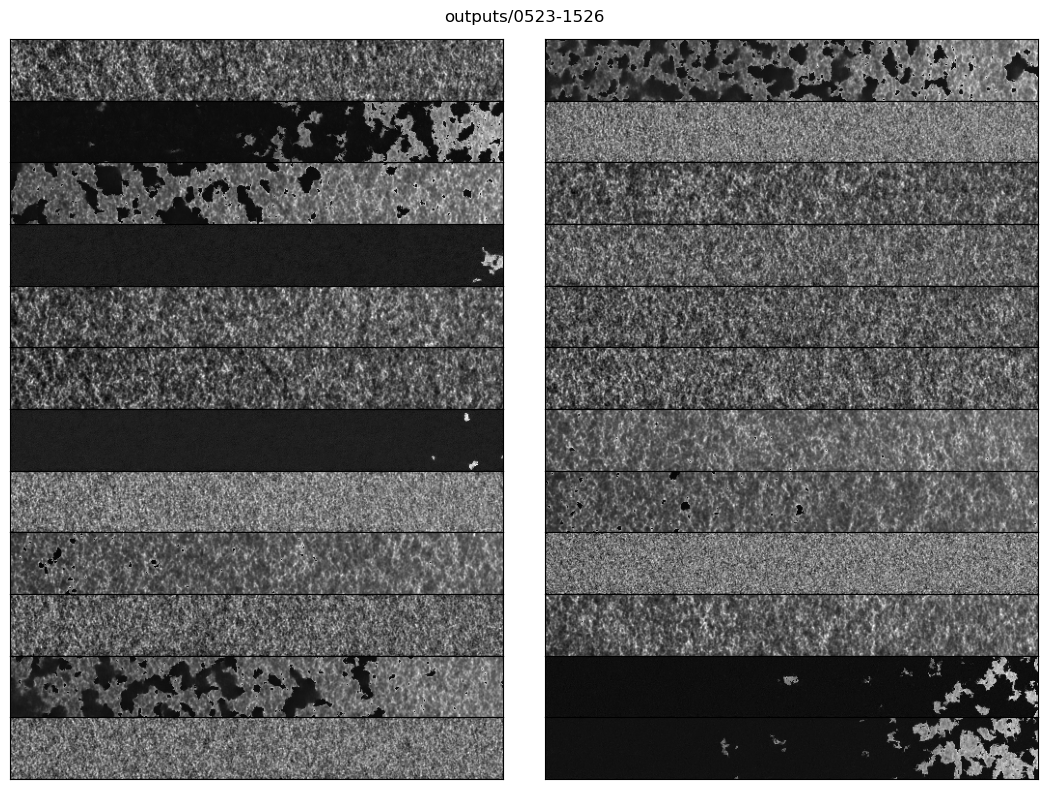

In [10]:
plot("outputs/0523-1526.npy")
# plot("outputs/0520-2323.npy")

In [1]:
from huggingface_hub import notebook_login
notebook_login()
from accelerate import notebook_launcher
import torch
from dataclasses import dataclass
import datasets
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from accelerate import Accelerator, notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from time import sleep
import matplotlib.pyplot as plt
from diffusers import UNet2DModel

@dataclass
class TrainingConfig:
    image_size = 128
    batch_size = 16
    eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'
    output_dir = "ddpm-butterflies-128"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()


config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split='train')

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

model = UNet2DModel(
    sample_size = config.image_size,
    in_channels = 3,
    out_channels = 3,
    layers_per_block = 2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D',
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = len(dataloader) * config.num_epochs,
)


def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')


def train_loop(config, model, noise_scheduler, optimizer, dataloader, lr_scheduler):
    import torch
    import numpy as np
    accelerator = Accelerator(
        mixed_precision = config.mixed_precision,
        gradient_accumulation_steps = config.gradient_accumulation_steps,
        log_with = 'tensorboard',
        project_dir = os.path.join(config.output_dir, 'logs'),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id = config.hub_model_id or Path(config.output_dir).name,
                exist_ok = True,
            ).repo_id
        accelerator.init_trackers('training_example')
    
    model, optimizer, dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, dataloader, lr_scheduler,
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(dataloader):
            clean_images = batch['images']
            # print(clean_images.device)
            # sleep(1)
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device, dtype=torch.int64
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                # print("loss:", loss)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id = repo_id,
                        folder_path = config.output_dir,
                        commit_message = f'Epoch {epoch}',
                        ignore_patterns=['step_*', 'epoch_*'],                        
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

# args = (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler)

device_count = torch.cuda.device_count()
notebook_launcher(train_loop, (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler), num_processes=2)

Repo card metadata block was not found. Setting CardData to empty.


Launching training on 2 GPUs.


RuntimeError: CUDA has been initialized before the `notebook_launcher` could create a forked subprocess. This likely stems from an outside import causing issues once the `notebook_launcher()` is called. Please review your imports and test them when running the `notebook_launcher()` to identify which one is problematic and causing CUDA to be initialized.

# test on 21cm dataset

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import numpy as np
from accelerate import notebook_launcher
import torch
from dataclasses import dataclass
import datasets
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from accelerate import Accelerator, notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from time import sleep
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
import h5py
from datasets import Dataset

@dataclass
class TrainingConfig:
    num_images = 600
    image_size = [64,512]
    batch_size = 10
    eval_batch_size = 24
    num_epochs = 20
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 20
    mixed_precision = 'fp16'
    output_dir = "diffusion21cm"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()
# config.dataset_name = "diffusion21cm"
# dataset = load_dataset(config.dataset_name, split='train')

In [ ]:
ls $SCRATCH/

datasets/             LEN512-DIM256.h5    token
LEN128-DIM64-CUB8.h5  max_redshift.ipynb  version_diffusers_cache.txt


In [ ]:
with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8.h5", 'r') as f:
    print(f.keys())
    print(f['brightness_temp'])
    Tb = f['brightness_temp'][:config.num_images,0,:config.image_size[0],:config.image_size[1]]
# Tb = Tb[:,None]
print(Tb.shape)

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
<HDF5 dataset "brightness_temp": shape (51200, 64, 64, 514), type "<f4">
(600, 64, 512)


(600, 64, 512)
<class 'numpy.ndarray'>


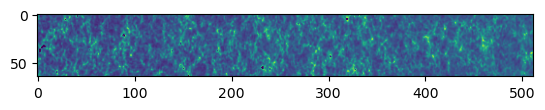

In [ ]:
print(Tb.shape)
print(type(Tb))
# plt.imshow(Tb[0])
plt.imshow(Tb[0])

In [ ]:
# config.dataset_name = "huggan/smithsonian_butterflies_subset"
# dataset = load_dataset(config.dataset_name, split='train')
# print(dataset.shape)
# print(type(dataset))
# print(dataset)
# print(dataset[0]['image'].convert('RGB'))
# print(np.shape(dataset[0]['image']))
# dataset[0]['image'].convert('RGB')

In [ ]:
def load_numpy_dataset(np_array, split='train'):
    assert split in ['train', 'test', 'validation'], "Invalid split name. Use 'train', 'test', or 'validation'."
    dataset = Dataset.from_dict({'image': np_array})
    return dataset
dataset = load_numpy_dataset(Tb)
print(type(dataset))
print(len(dataset))
print(np.shape(dataset))
print(dataset)
print(np.shape(dataset[0]['image']))

<class 'datasets.arrow_dataset.Dataset'>
600
(600, 1)
Dataset({
    features: ['image'],
    num_rows: 600
})
(64, 512)


In [ ]:
# test = np.array(dataset[0]['image'])
# print(test.shape)
# print(test.min(), test.max())
# test = (test-test.min())/(test.max()-test.min())
# # plt.imshow((test*255).astype(np.int))
# plt.imshow(test)
# plt.show()

In [ ]:
def normalize(image):
    initial_data = np.array(image)
    data = (initial_data - initial_data.min()) / (initial_data.max()-initial_data.min())
    # data = (normalized_data*255).astype(np.uint8)
    data = Image.fromarray(np.uint8(data*255))
    return data

preprocess = transforms.Compose(
    [
        # normalize(),
        transforms.Resize((config.image_size[0], config.image_size[1])),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transform(examples):
    images = [preprocess(normalize(image)) for image in examples['image']]
    # images = [preprocess(image) for image in examples['image']]
    # print(np.shape(images[0]))
    return {"images": images}

# datasets = transform(Tb)
dataset.set_transform(transform)

In [ ]:
dataset[0]['images'].shape

torch.Size([1, 64, 512])

In [ ]:
dataset[3]['images'].shape

torch.Size([1, 64, 512])

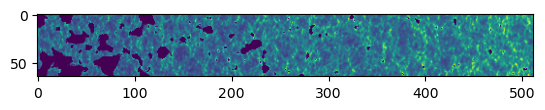

In [ ]:
plt.imshow(dataset[4]['images'][0])

In [ ]:
# dataset.set_transform(transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

In [ ]:
next(iter(dataloader))['images'].shape

torch.Size([10, 1, 64, 512])

In [ ]:
model = UNet2DModel(
    sample_size = config.image_size,
    in_channels = 1,
    out_channels = 1,
    layers_per_block = 2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D',
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = len(dataloader) * config.num_epochs,
)


def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=12, cols=2)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')


def train_loop(config, model, noise_scheduler, optimizer, dataloader, lr_scheduler):
    import torch
    import numpy as np
    accelerator = Accelerator(
        mixed_precision = config.mixed_precision,
        gradient_accumulation_steps = config.gradient_accumulation_steps,
        log_with = 'tensorboard',
        project_dir = os.path.join(config.output_dir, 'logs'),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id = config.hub_model_id or Path(config.output_dir).name,
                exist_ok = True,
            ).repo_id
        accelerator.init_trackers('training_example')
    
    model, optimizer, dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, dataloader, lr_scheduler,
    )

    global_step = 0
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
    
        
        for step, batch in enumerate(dataloader):
            clean_images = batch['images']
            # print(clean_images.device)
            # sleep(1)
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device, dtype=torch.int64
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                # print("loss:", loss)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id = repo_id,
                        folder_path = config.output_dir,
                        commit_message = f'Epoch {epoch}',
                        ignore_patterns=['step_*', 'epoch_*'],                        
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)


In [ ]:
# args = (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler)
device_count = torch.cuda.device_count()
notebook_launcher(train_loop, (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler), num_processes=1)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0009.png:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1715452041.atl1-1-03-003-19-0.pace.gatech.edu.11077.0:   0%|          | 0.00/152k [00:00<?…

0019.png:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

loss = 0.0133